<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
orig = pd.read_csv('./housing.csv')

In [4]:
house.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


Doing a quick data exploration. As real estate is generally about location, we shall see how much prices of the neighbourhoods differ.

In [5]:
(house.groupby('Neighborhood')['SalePrice'].mean() / house.groupby('Neighborhood')['GrLivArea'].mean()).sort_values(ascending=False)

Neighborhood
StoneBr    165.239905
NridgHt    165.072651
Veenker    155.083845
Somerst    141.157845
Timber     138.477089
Blmngtn    136.469825
CollgCr    133.715484
NoRidge    133.644829
Mitchel    120.746121
ClearCr    118.877344
Crawfor    117.561846
Gilbert    117.499892
SawyerW    116.961639
NPkVill    113.882238
Sawyer     112.574422
NAmes      111.307215
NWAmes     109.417853
BrkSide    103.763006
Blueste     98.743268
Edwards     95.683487
MeadowV     93.089657
BrDale      91.405609
IDOTRR      87.651248
OldTown     86.654779
SWISU       79.162888
dtype: float64

In [6]:
#house.groupby('Neighborhood').size().sort_values(ascending=False)
#pd.options.display.float_format = '{:,.2f}'.format
print('Mean saleprice for Ames dataset: ' + str(house['SalePrice'].mean()))
house.groupby('Neighborhood')['SalePrice'].describe().unstack().sort_values(ascending=False)['mean']

Mean saleprice for Ames dataset: 180921.19589041095


Neighborhood
NoRidge    335295.317073
NridgHt    316270.623377
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Somerst    225379.837209
ClearCr    212565.428571
Crawfor    210624.725490
CollgCr    197965.773333
Blmngtn    194870.882353
Gilbert    192854.506329
NWAmes     189050.068493
SawyerW    186555.796610
Mitchel    156270.122449
NAmes      145847.080000
NPkVill    142694.444444
SWISU      142591.360000
Blueste    137500.000000
Sawyer     136793.135135
OldTown    128225.300885
Edwards    128219.700000
BrkSide    124834.051724
BrDale     104493.750000
IDOTRR     100123.783784
MeadowV     98576.470588
dtype: float64

Interesting to see the top three neighbourhoods have average sale prices >120k above the general average sale price. Useful predictors maybe?

Going to review the condition feature too to see which have a positive impact on price.

In [7]:
house.groupby('Condition1')[['SalePrice']].mean()
#house.groupby('Condition1')['SalePrice'].size()

,SalePrice
Condition1,
Artery,135091.666667
Feedr,142475.481481
Norm,184495.492063
PosA,225875.000000
PosN,215184.210526
RRAe,138400.000000
RRAn,184396.615385
RRNe,190750.000000
RRNn,212400.000000


Parks and railroads seem to have a positive impact on price. 

In [8]:
#Setup an ordered list of neighbourhoods
Ordered_Nbs = list(house.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index)

In [9]:
print('mean price for best 5 neighbourhoods: ' + str(house[house['Neighborhood'].isin(Ordered_Nbs[:5])]['SalePrice'].mean()))
print('mean lot area for best 5 neighbourhoods: ' + str(house[house['Neighborhood'].isin(Ordered_Nbs[:5])]['LotArea'].mean()))

print('mean price for worst 5 neighbourhoods: ' + str(house[house['Neighborhood'].isin(Ordered_Nbs[-5:])]['SalePrice'].mean()))
print('mean lot area for worst 5 neighbourhoods: ' + str(house[house['Neighborhood'].isin(Ordered_Nbs[-5:])]['LotArea'].mean()))

mean price for best 5 neighbourhoods: 300491.2708333333
mean lot area for best 5 neighbourhoods: 14370.0625
mean price for worst 5 neighbourhoods: 118923.79385964913
mean lot area for worst 5 neighbourhoods: 7969.877192982456


In [10]:
house.groupby('BldgType')['SalePrice'].mean()

BldgType
1Fam      185763.807377
2fmCon    128432.258065
Duplex    133541.076923
Twnhs     135911.627907
TwnhsE    181959.342105
Name: SalePrice, dtype: float64

From above, we can see that some house types seem more desirable. Single family detached and townhouses end unit have the highest mean price. Shall take a look at the mean price by type and neighbourhood.

In [11]:
house.groupby(['Neighborhood','BldgType'])['SalePrice'].mean().unstack().sort_values(by='1Fam',ascending=False)

BldgType,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
Neighborhood,,,,,
StoneBr,393267.307692,NaN,NaN,NaN,220833.333333
NridgHt,351629.418182,NaN,NaN,192214.285714,244514.666667
NoRidge,335295.317073,NaN,NaN,NaN,NaN
Somerst,247923.406780,NaN,NaN,167533.333333,180410.277778
Timber,242606.837838,228950.000000,NaN,NaN,NaN
Veenker,223375.000000,NaN,NaN,NaN,279833.333333
ClearCr,212565.428571,NaN,NaN,NaN,NaN
Crawfor,208719.133333,157000.000000,145000.000000,NaN,300833.333333
CollgCr,201858.328571,NaN,NaN,NaN,143470.000000


To note: In the'nicest' neighbourhoods, single family detached is most valuable, while townhouses trend better in average neighbourhoods, especially crawford and bloomington.

In [12]:
#defining fixed/non-fixed features
feature_dict = {
    'fixed': ['MSSubClassCat'
,'MSZoning'
,'LotFrontage'
,'LotArea'
,'Street'
,'Alley'
,'LotShape'
,'LandContour'
,'Utilities'
,'LotConfig'
,'LandSlope'
,'Neighborhood'
,'Condition1'
,'Condition2'
,'BldgType'
,'YearBuilt'
,'YearRemodAdd'
,'RoofStyle'
,'Foundation'
,'BsmtQual'
,'BsmtExposure'
,'GarageYrBlt'
,'MoSold'
,'YrSold'
,'SaleType'
,'SaleCondition'
,'SalePrice'],
    'non-fixed': ['HouseStyle'
,'OverallQual'
,'OverallCond'
,'RoofMatl'
,'Exterior1st'
,'Exterior2nd'
,'MasVnrType'
,'MasVnrArea'
,'ExterQual'
,'ExterCond'
,'BsmtCond'
,'BsmtFinType1'
,'BsmtFinSF1'
,'BsmtFinType2'
,'BsmtFinSF2'
,'BsmtUnfSF'
,'TotalBsmtSF'
,'Heating'
,'HeatingQC'
,'CentralAir'
,'Electrical'
,'1stFlrSF'
,'2ndFlrSF'
,'LowQualFinSF'
,'GrLivArea'
,'BsmtFullBath'
,'BsmtHalfBath'
,'FullBath'
,'HalfBath'
,'BedroomAbvGr'
,'KitchenAbvGr'
,'KitchenQual'
,'TotRmsAbvGrd'
,'Functional'
,'Fireplaces'
,'FireplaceQu'
,'GarageType'
,'GarageFinish'
,'GarageCars'
,'GarageArea'
,'GarageQual'
,'GarageCond'
,'PavedDrive'
,'WoodDeckSF'
,'OpenPorchSF'
,'EnclosedPorch'
,'3SsnPorch'
,'ScreenPorch'
,'PoolArea'
,'PoolQC'
,'Fence'
,'MiscFeature'
,'MiscVal'
,'SalePrice']
}

print(feature_dict)

{'fixed': ['MSSubClassCat', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageYrBlt', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'], 'non-fixed': ['HouseStyle', 'OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckS

In [13]:
#Removing commercial properties from dataset
house.groupby(['MSZoning']).size()

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
dtype: int64

In [14]:
house = house[house['MSZoning'] != 'C (all)']

In [15]:
house.groupby(['MSZoning']).size()

MSZoning
FV      65
RH      16
RL    1151
RM     218
dtype: int64

In [16]:
#set ID as the index
house.set_index('Id',inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cca7748>,
      dtype=object)

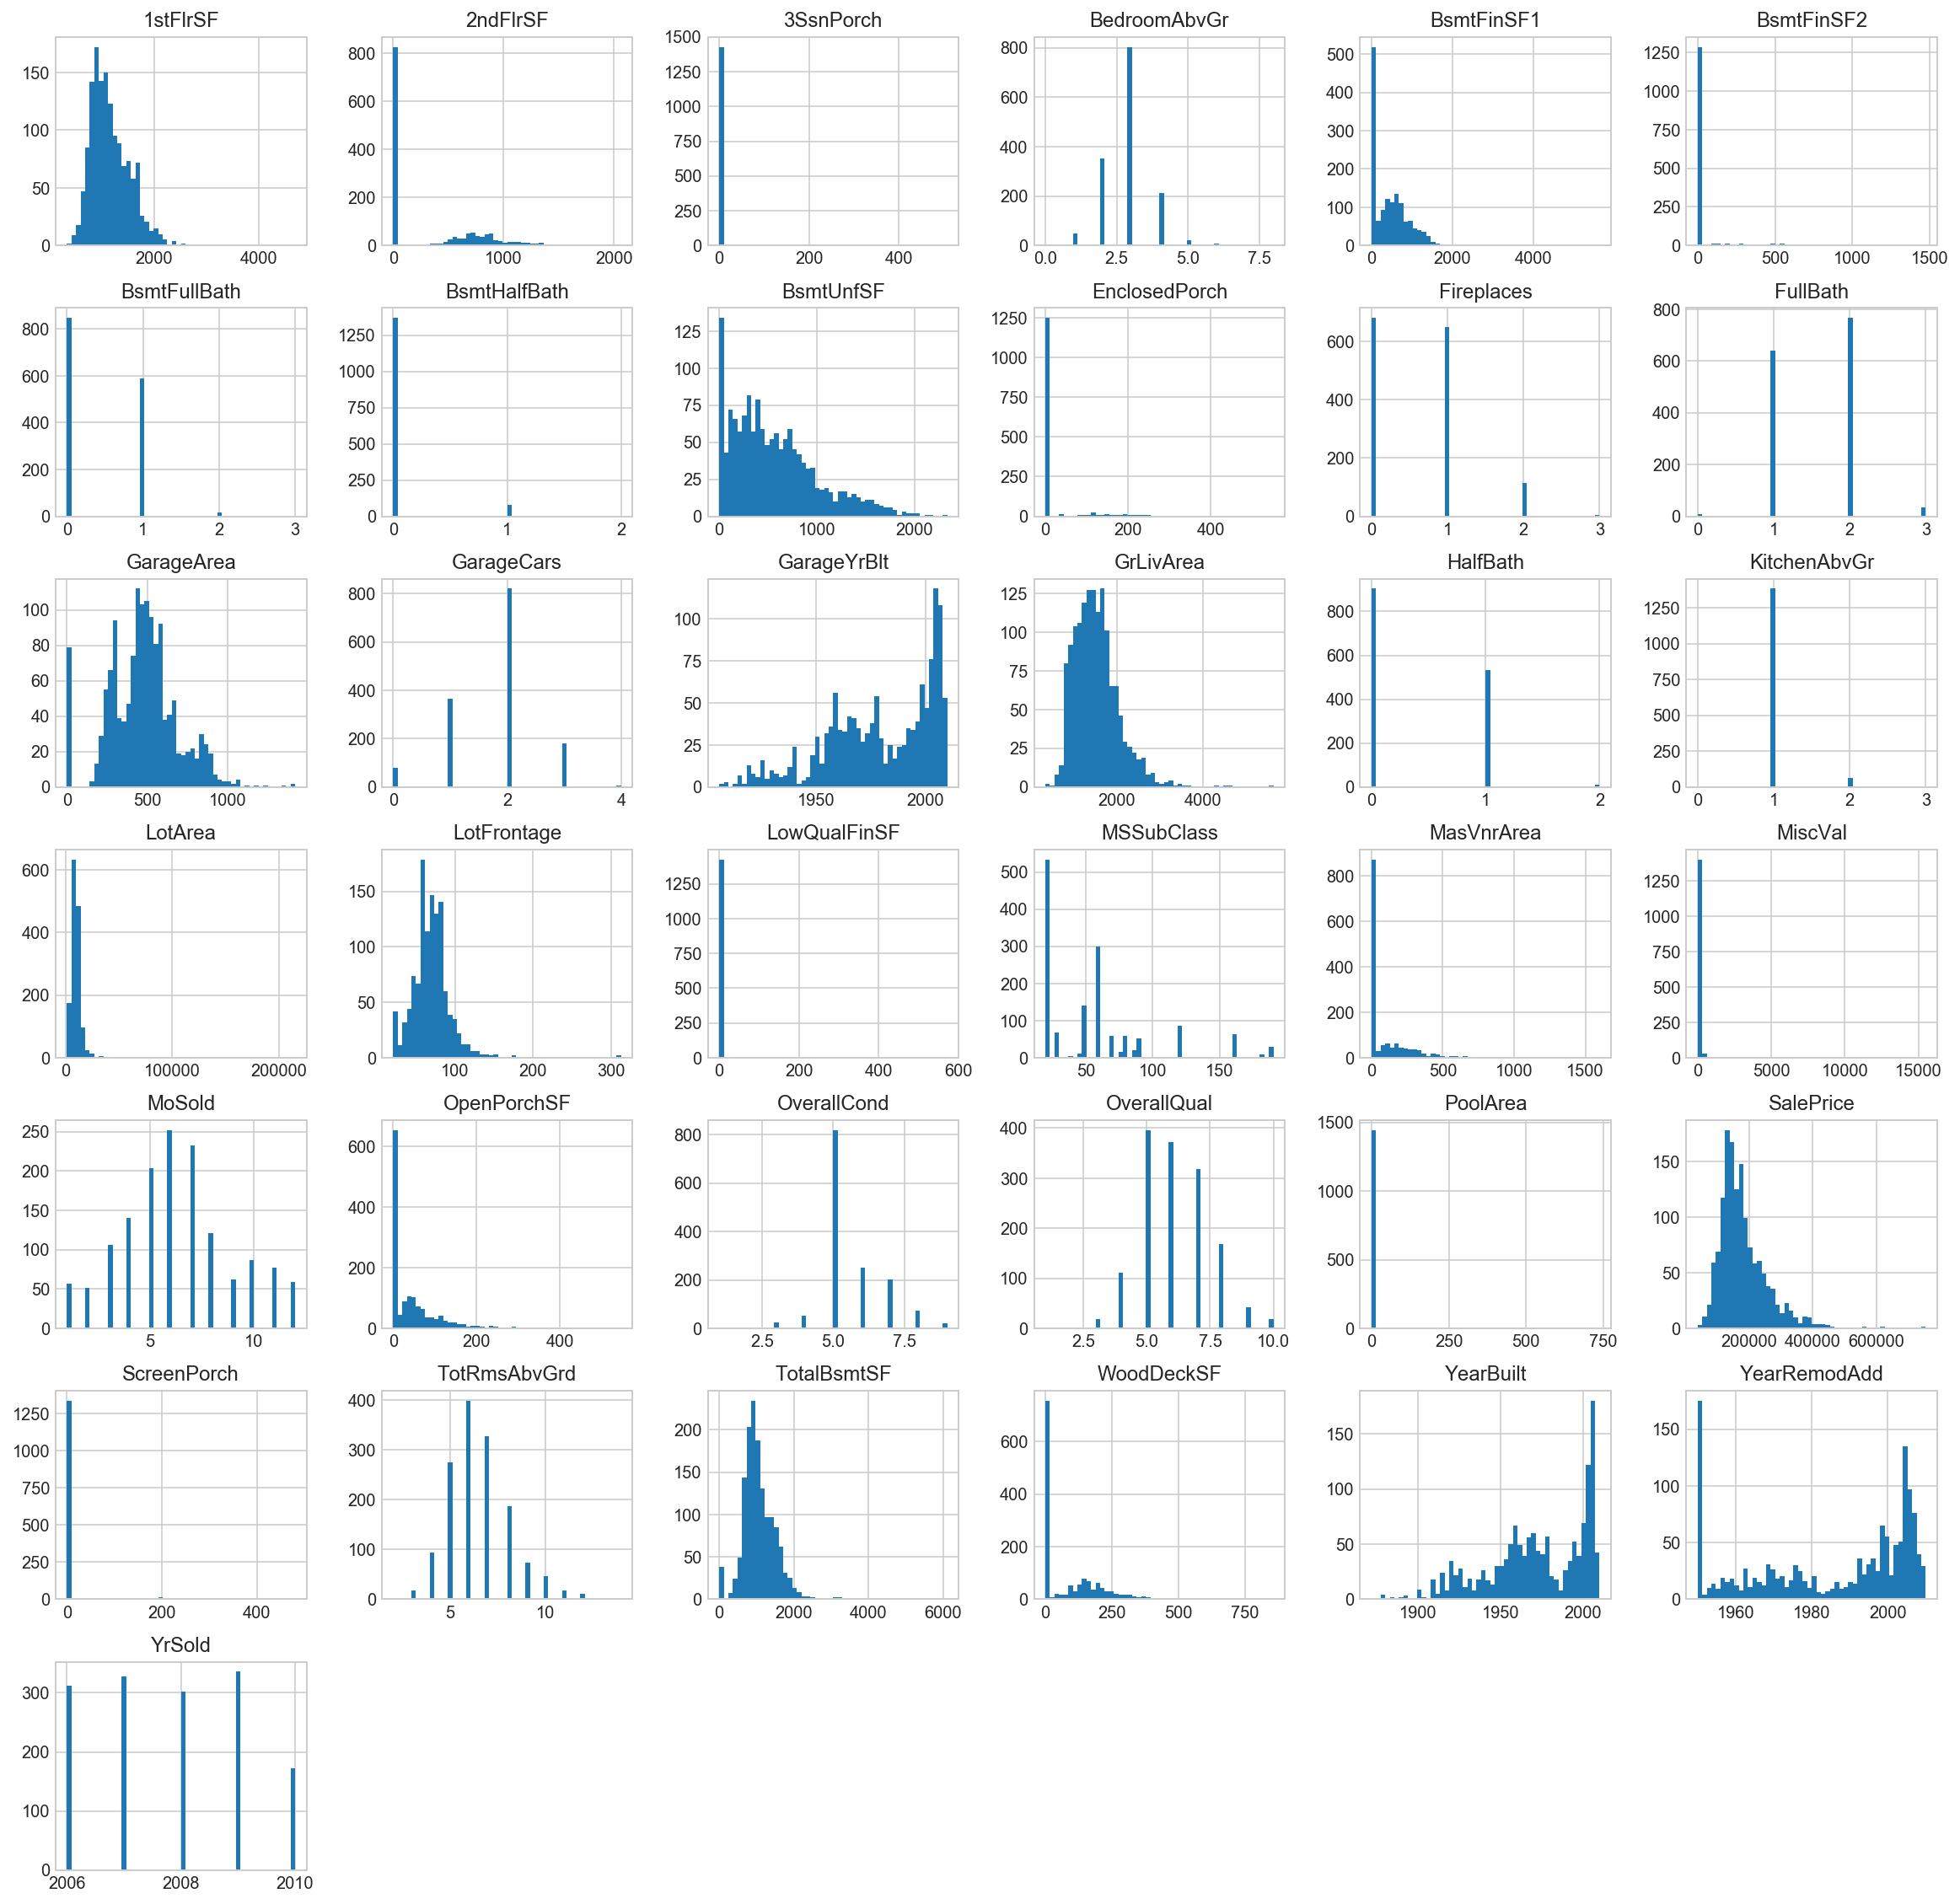

In [17]:
#taking a look at top pair plots with hist.
house.hist(bins=50,figsize=(20,20))

In [18]:
#Removing columns with less than 90% of data 
#Keeping all columns that have more than 10% null values
print((1 - (house.isnull().sum().sort_values(ascending=False) / len(house)) < .9).head(10))
house.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'],axis=1,inplace=True)

PoolQC           True
MiscFeature      True
Alley            True
Fence            True
FireplaceQu      True
LotFrontage      True
GarageType      False
GarageCond      False
GarageFinish    False
GarageQual      False
dtype: bool


In [19]:
#Converting MSSubClass to Categorical
def MSconvert(num):
    MS_dict = {
        20: '1STORY1946',
        30: '1STORY1945',
        40: '1STORYATTIC',
        45: '1.5STORYUNFIN',
        50: '1.5STORYFIN',
        60: '2STORY1946N',
        70: '2STORY1945O',
        75: '2.5STORY',
        80: 'SPLITLEVEL',
        85: 'SPLITFOYER',
        90: 'DUPLEX',
       120: '1STORYPUD',
       150: '1.5STORYPUD',
       160: '2STORYPUD',
       180: 'MULTILEVELPUD',
       190: '2FAMILY'}
    return MS_dict[num]

MSconvert(orig['MSSubClass'][0])

'2STORY1946N'

In [20]:
house['MSSubClassCat'] = house['MSSubClass'].apply(MSconvert)

In [21]:
house.drop('MSSubClass',axis=1,inplace=True)

In [22]:
#making a copy of dataset
hcopy = house.copy()

In [23]:
#Using fillna with median (for numeric features)

#np.median(house['GarageYrBlt'])
#house.info()

In [24]:
for col in house.columns:
    if house[col].dtype != 'object':
        house[col].fillna(value = house[col].median(), inplace=True)

In [25]:
for col in house.columns:
    if house[col].dtype == 'object':
        house[col].fillna(value = 'None', inplace=True)

In [26]:
#taking a look at Nans
house.isnull().sum().sort_values(ascending=False).head()

MSSubClassCat    0
RoofMatl         0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
dtype: int64

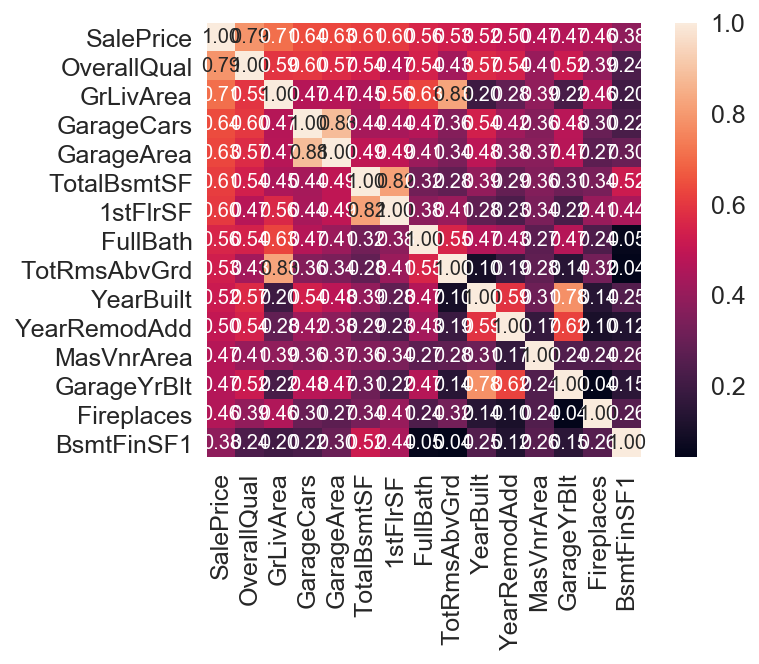

In [27]:
#correlation matrix with SalePrice

k = 15 #number of variables for heatmap
corr = house.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

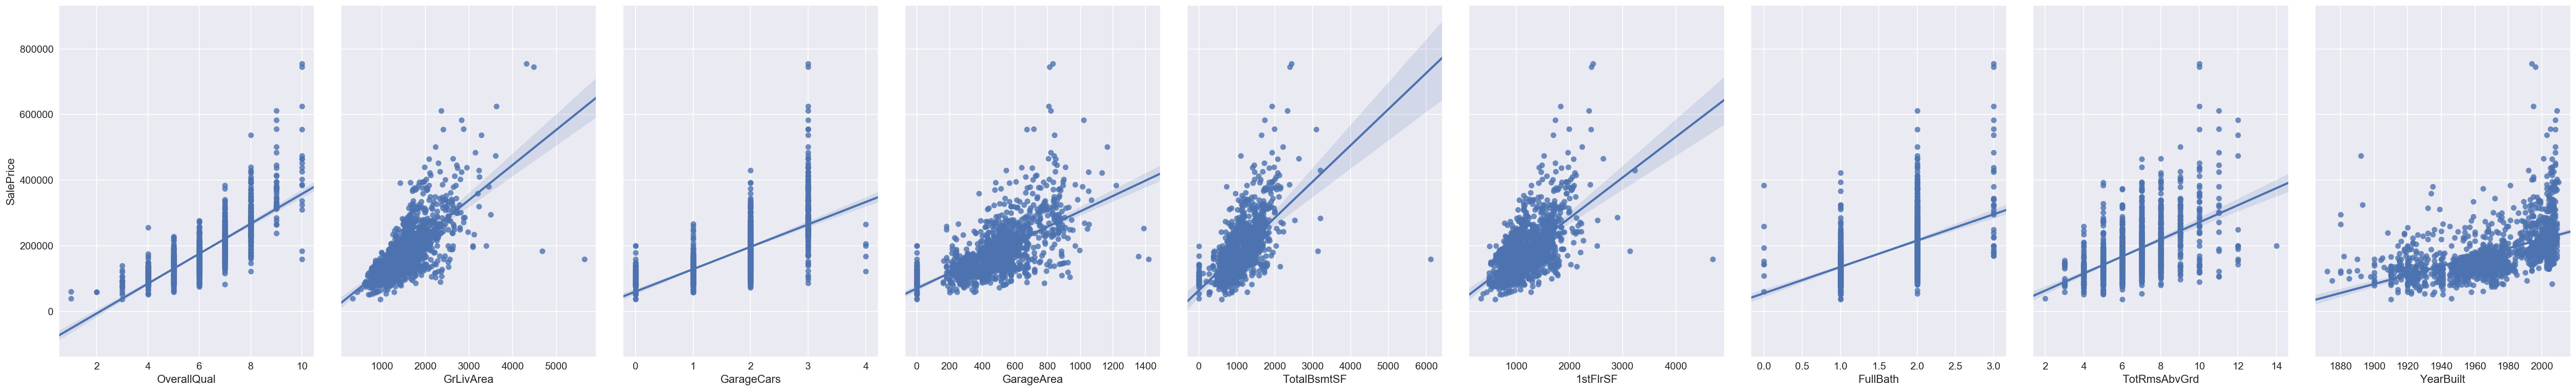

In [28]:
#pairplotting top correlations
sns.pairplot(house, x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
                            'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
             y_vars=['SalePrice'],size=7,aspect=.7,kind='reg')

Besides the obvious GrLivArea, interesting to see garages also being a key factor in price.

/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Use

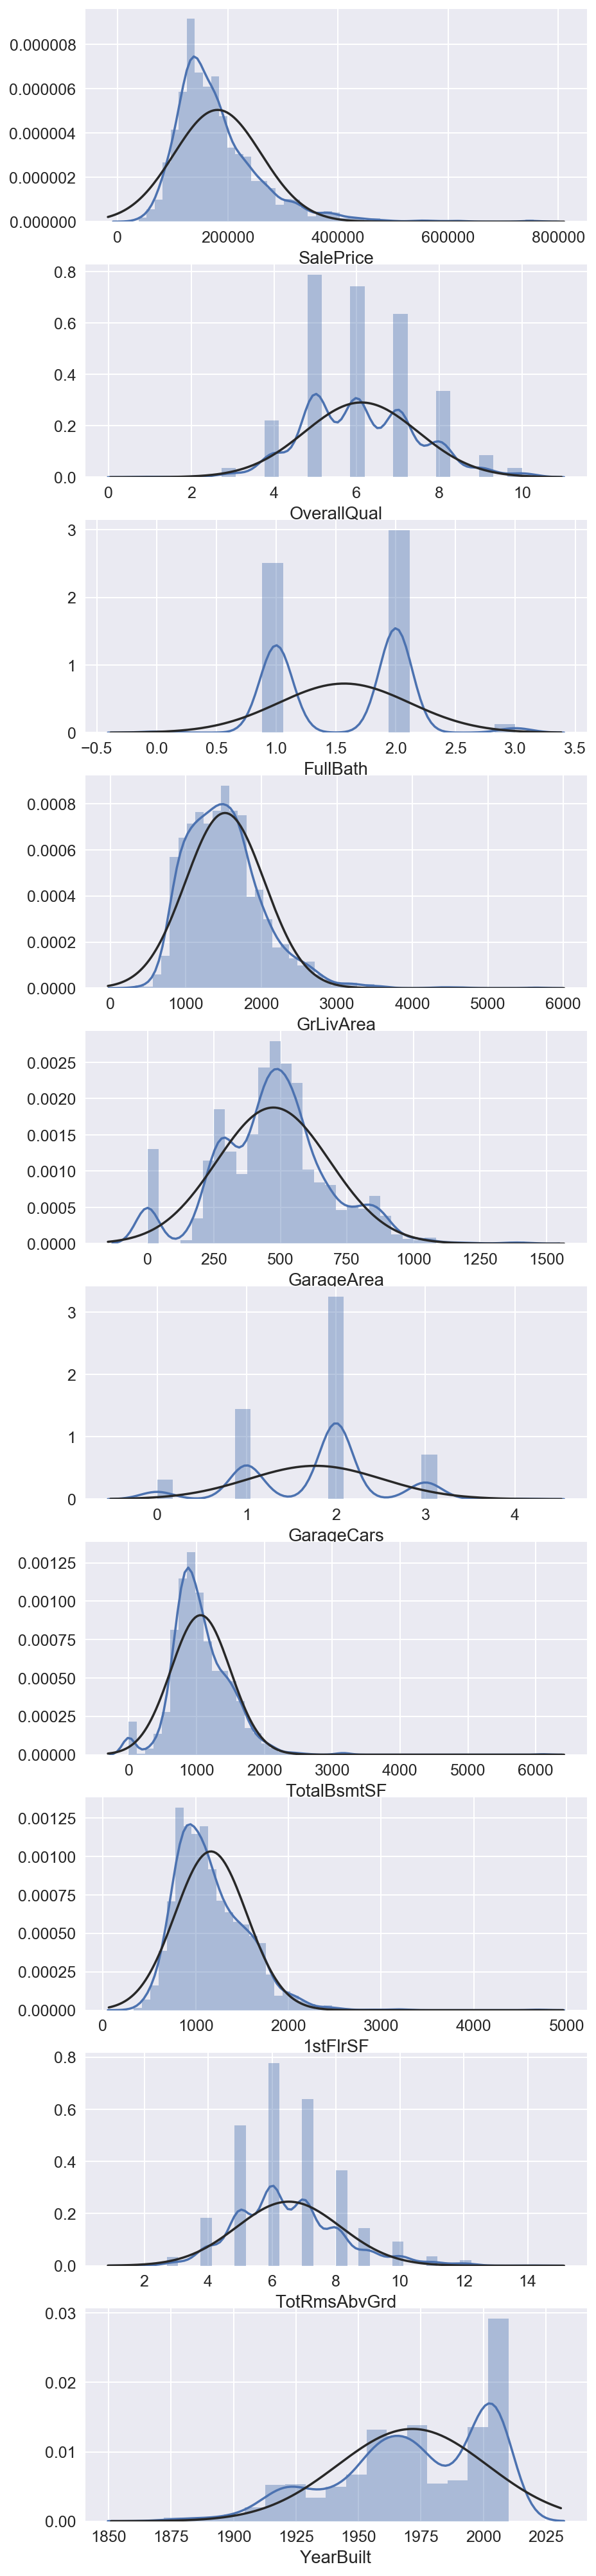

In [29]:
#Looking at distributions to see what type they are
from scipy.stats import norm
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10,figsize=(7,36))
sns.distplot(house['SalePrice'], fit=norm, ax=ax1)
sns.distplot(house['OverallQual'], fit=norm, ax=ax2)
sns.distplot(house['FullBath'], fit=norm, ax=ax3)
sns.distplot(house['GrLivArea'], fit=norm, ax=ax4)
sns.distplot(house['GarageArea'], fit=norm, ax=ax5)
sns.distplot(house['GarageCars'], fit=norm, ax=ax6)
sns.distplot(house['TotalBsmtSF'], fit=norm, ax=ax7)
sns.distplot(house['1stFlrSF'], fit=norm, ax=ax8)
sns.distplot(house['TotRmsAbvGrd'], fit=norm, ax=ax9)
sns.distplot(house['YearBuilt'], fit=norm, ax=ax10)

Looks like a few of the top variables are not normally distributed.

In [30]:
#making a cleaned no_transforms dataset copy
h_no_transforms = house.copy()
#h_no_log = h_no_transforms.copy()

Going to log transform variables that are not normally distributed.

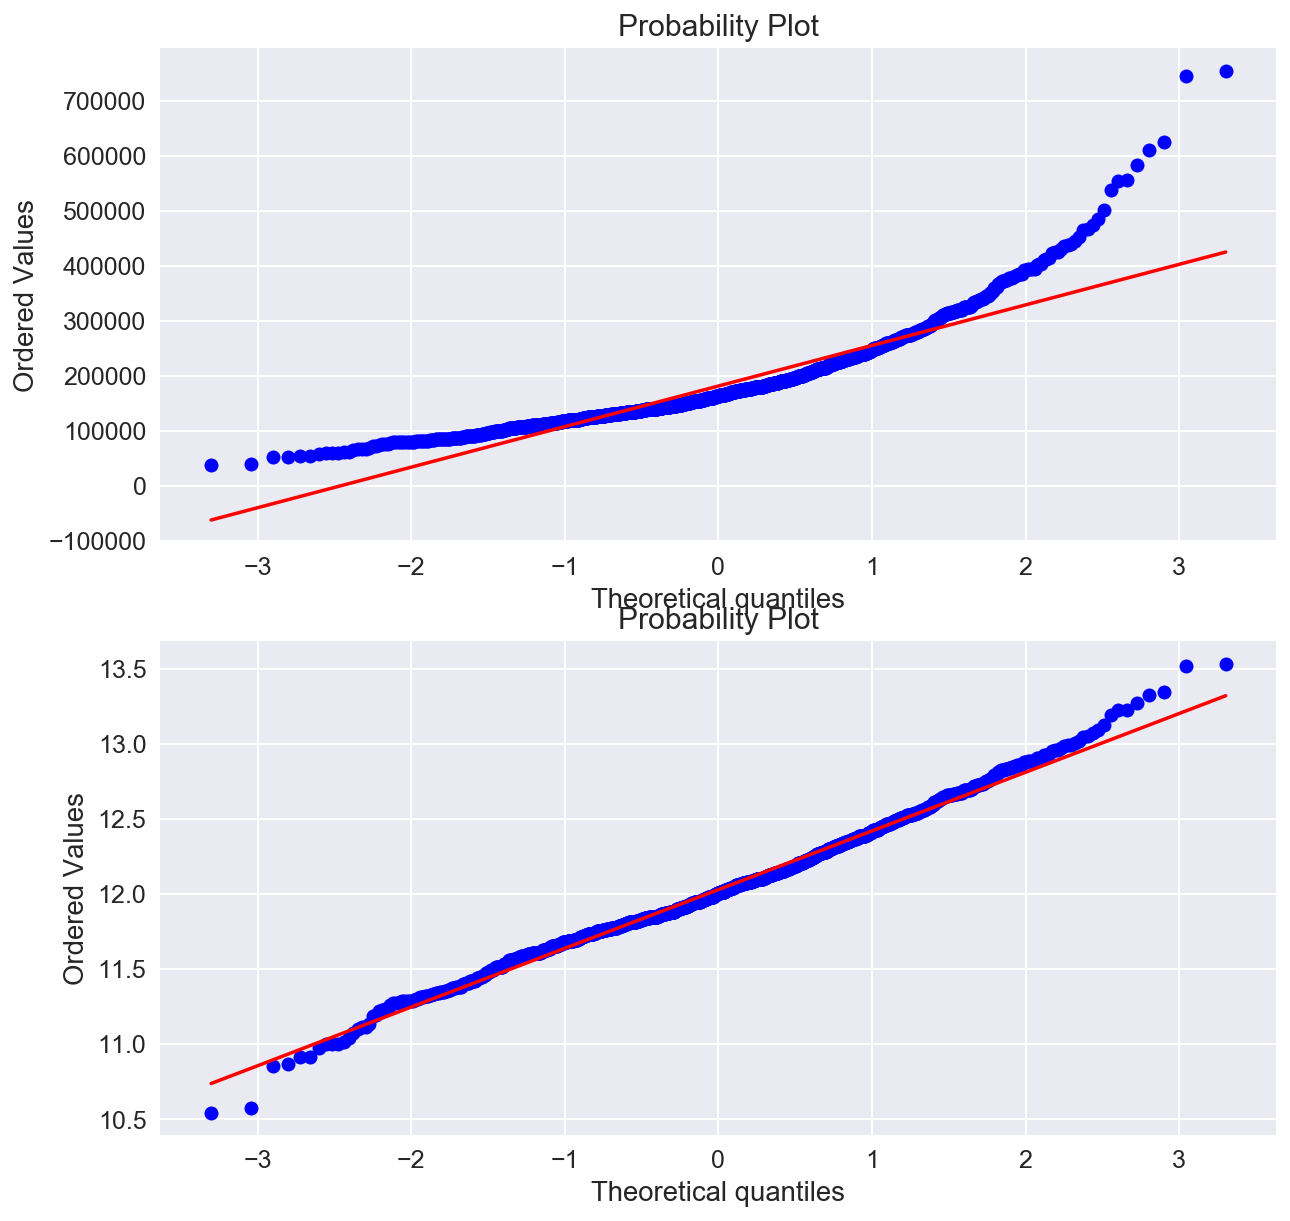

In [31]:
#saleprice
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house['SalePrice'], plot=ax1)
house['SalePrice'] = np.log(house['SalePrice'])
res = stats.probplot(house['SalePrice'], plot=ax2)

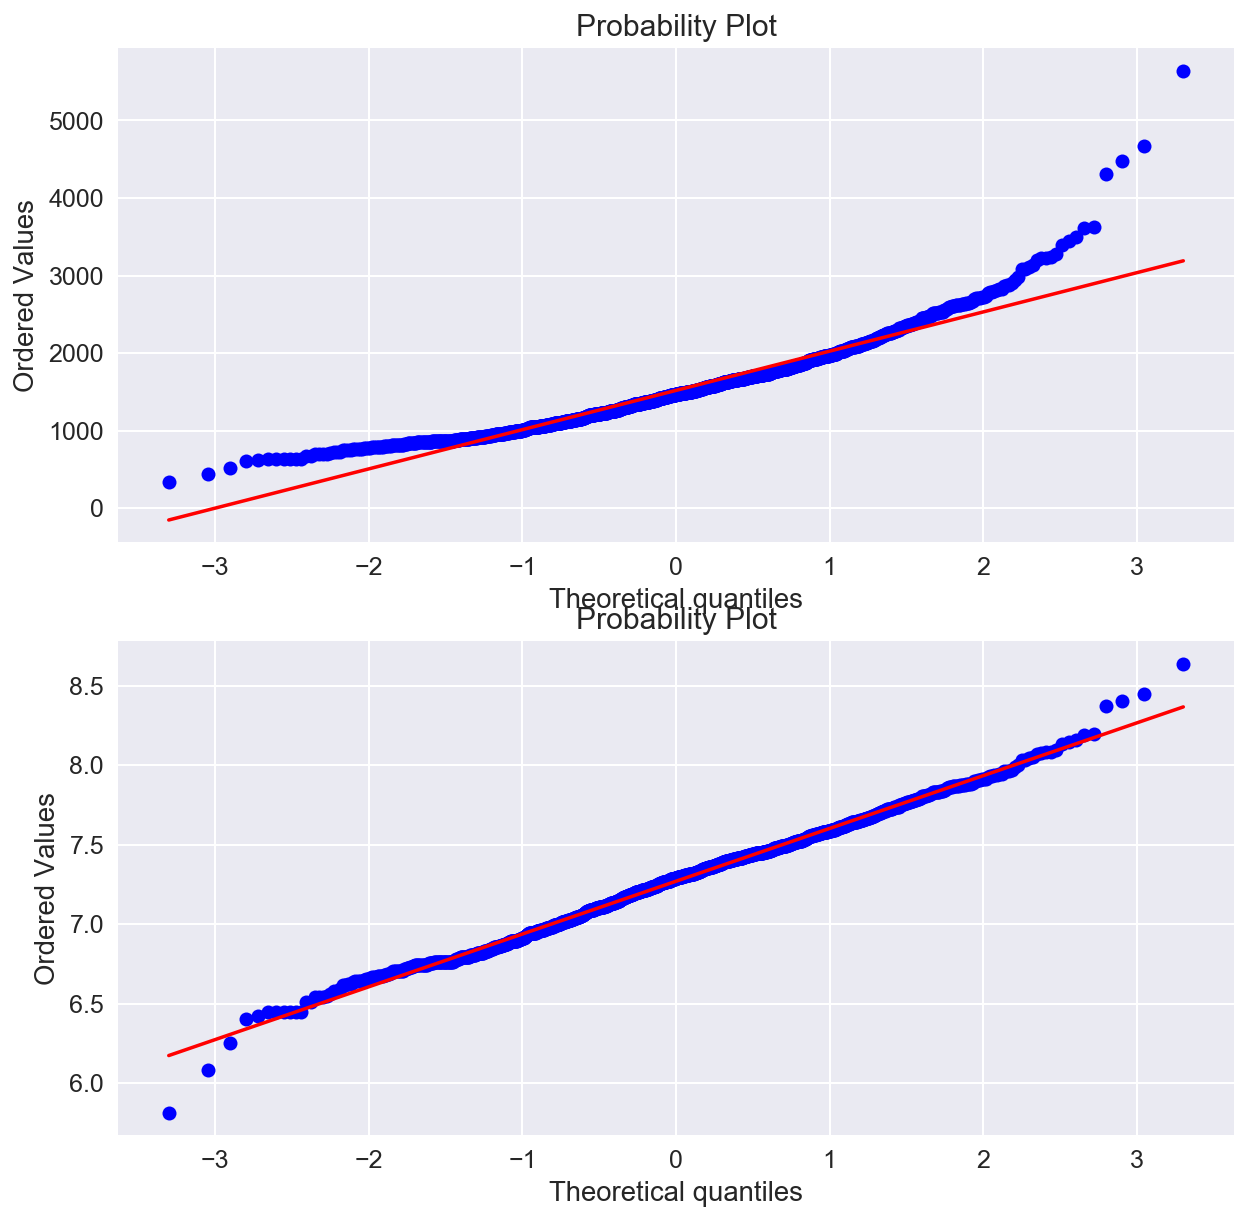

In [32]:
#GrLivArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house['GrLivArea'], plot=ax1)
house['GrLivArea'] = np.log(house['GrLivArea'])
res = stats.probplot(house['GrLivArea'], plot=ax2)

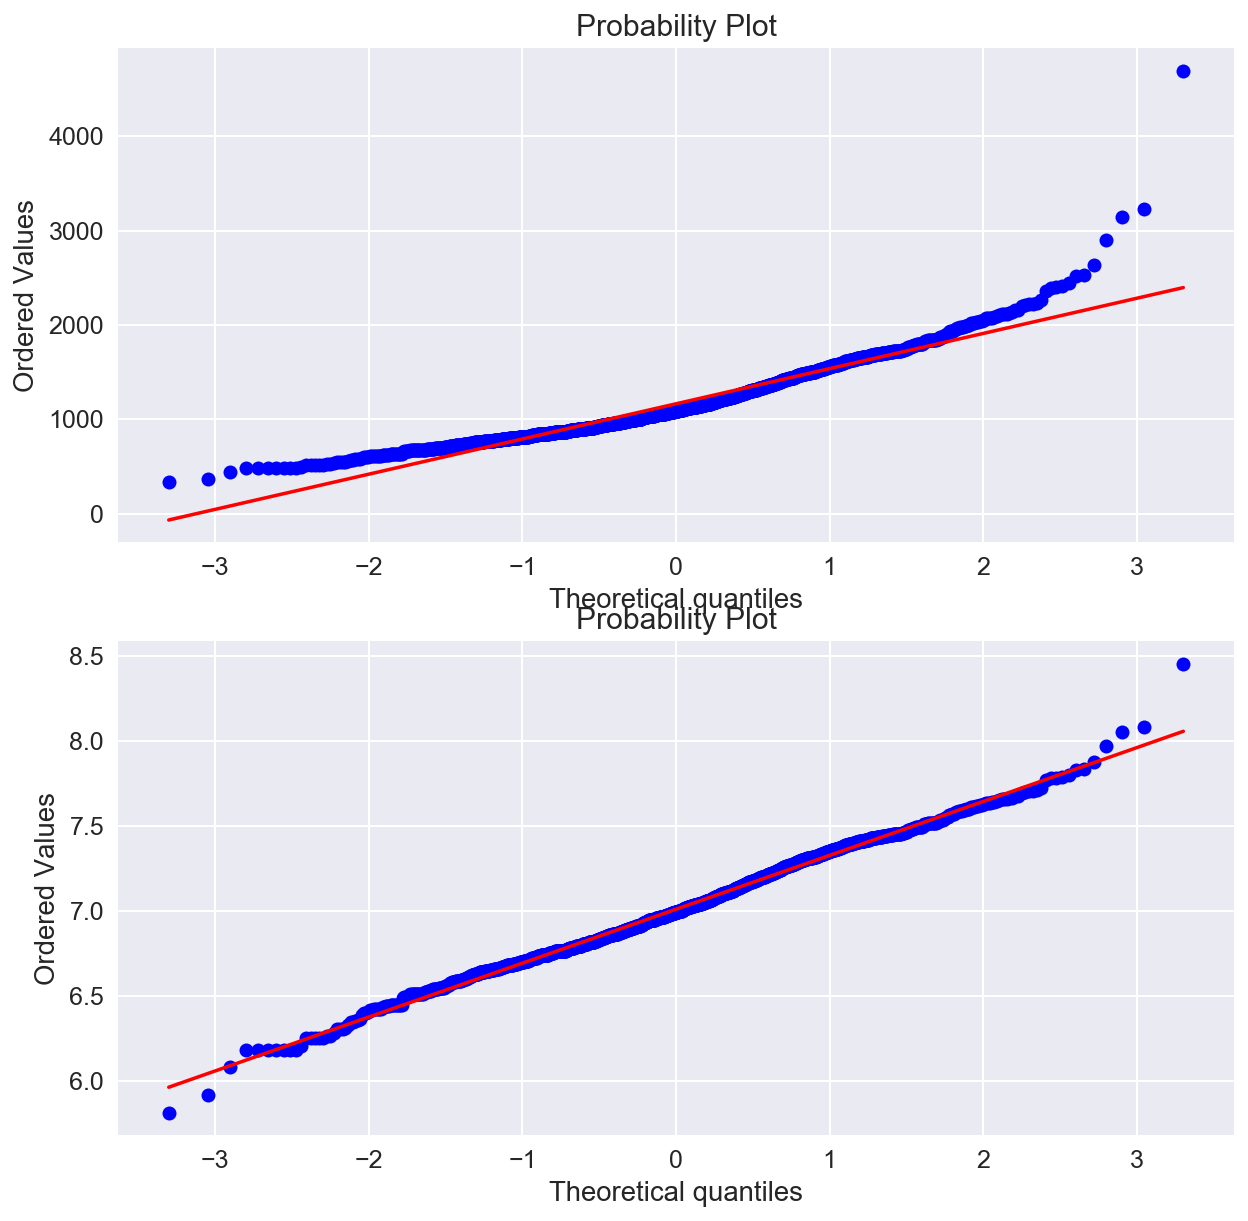

In [33]:
#1stFlrSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house['1stFlrSF'], plot=ax1)
house['1stFlrSF'] = np.log(house['1stFlrSF'])
res = stats.probplot(house['1stFlrSF'], plot=ax2)

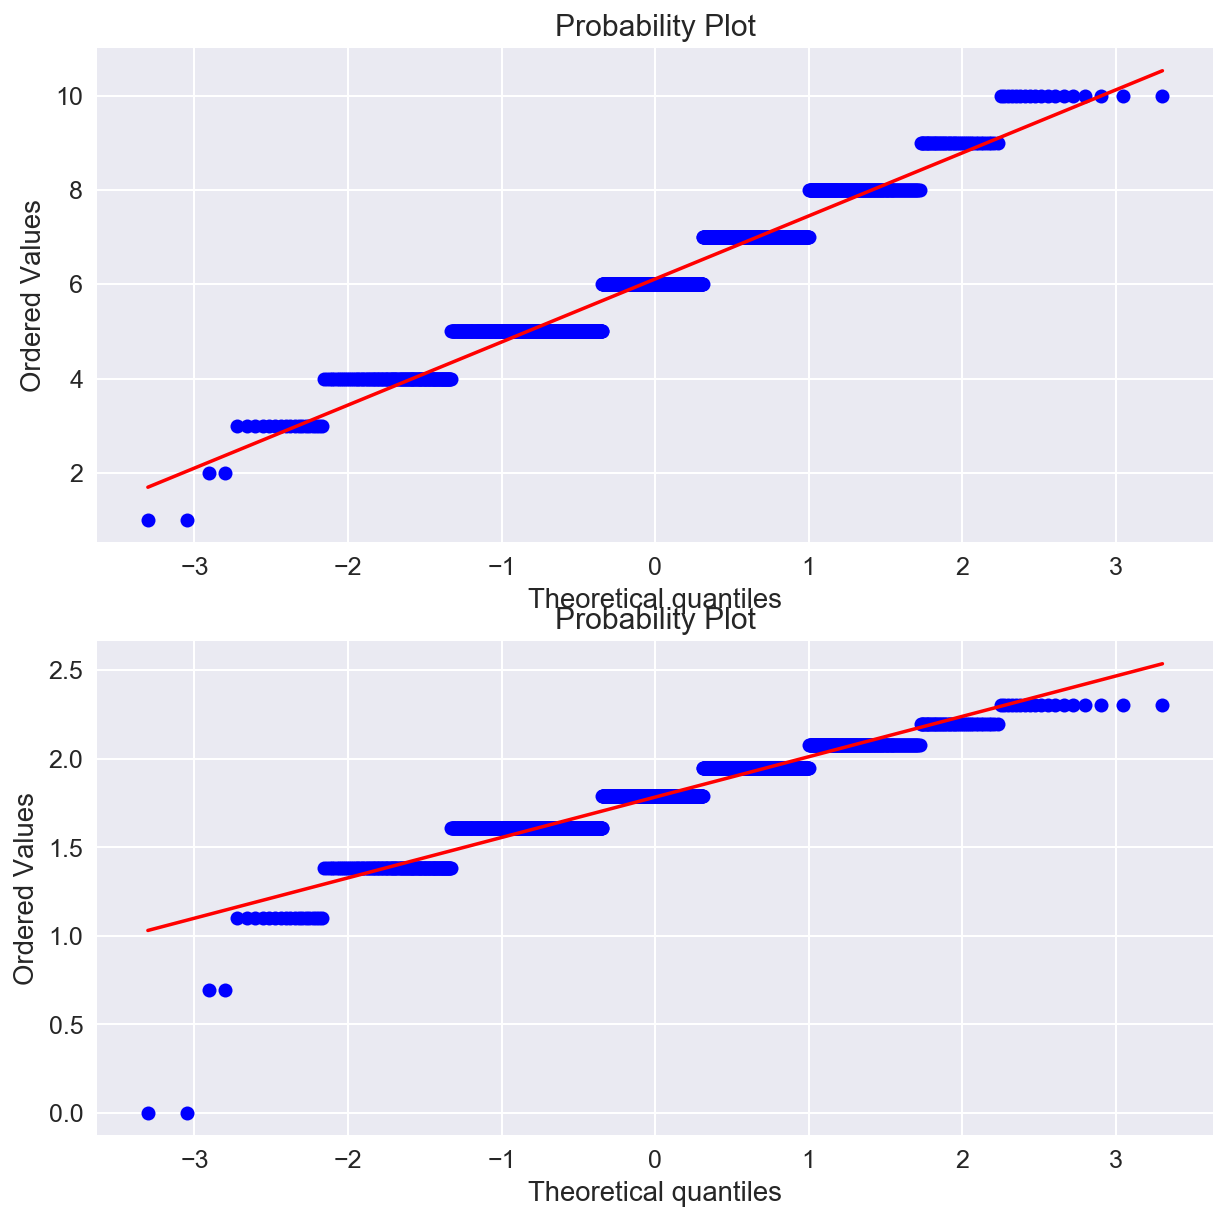

In [34]:
#OverallQual - not sure if this should have it but let's try?
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house['OverallQual'], plot=ax1)
house['OverallQual'] = np.log(house['OverallQual'])
res = stats.probplot(house['OverallQual'], plot=ax2)

In [35]:
#Convert 0's in some numerics to categorical
def Zeroconvert(num):
    if num == 0:
        out = 1
    else:
        out = 0
    return out
Zeroconvert(orig['TotalBsmtSF'][0])

0

In [36]:
#there are 37 houses without a basement
house['TotalBsmtSF'].value_counts().head()

0       37
864     35
672     17
912     15
1040    14
Name: TotalBsmtSF, dtype: int64

In [37]:
house['NoBsmt'] = house['TotalBsmtSF'].apply(Zeroconvert)

In [38]:
house['NoBsmt'].value_counts().head()

0    1413
1      37
Name: NoBsmt, dtype: int64

In [39]:
#there are 79 houses without a Garage
house['GarageArea'].value_counts().head()

0      79
440    49
576    47
240    38
484    34
Name: GarageArea, dtype: int64

In [40]:
house['NoGarage'] = house['GarageArea'].apply(Zeroconvert)

/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


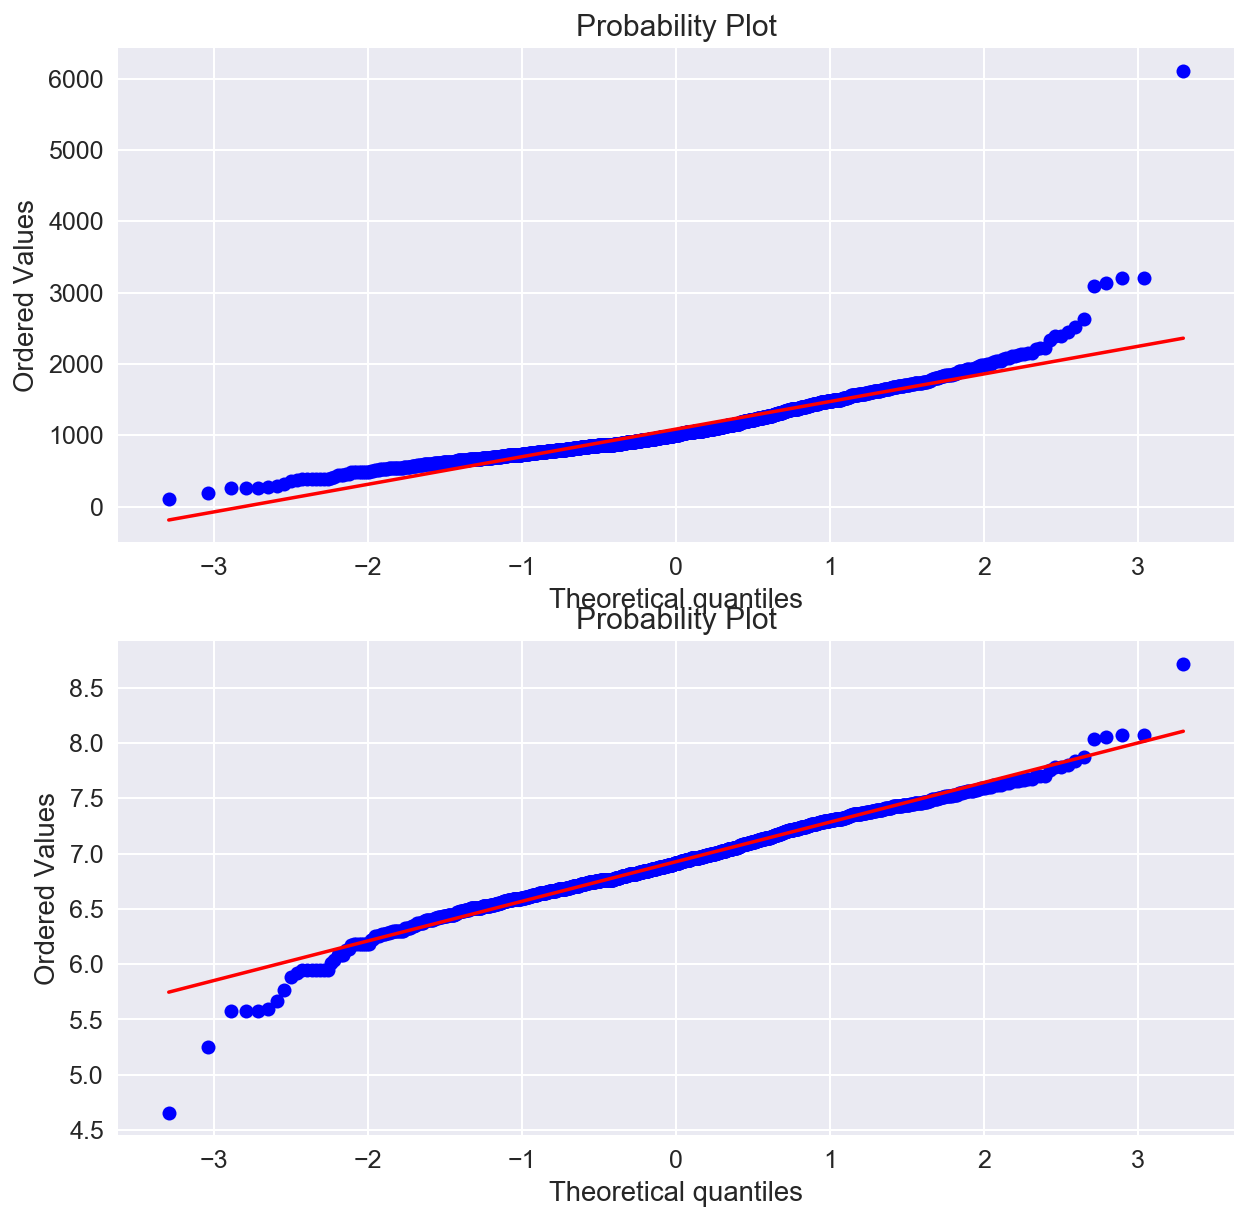

In [41]:
#TotalBsmtSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house[house['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax1)
house.loc[house['NoBsmt'] == 0,'TotalBsmtSF'] = np.log(house['TotalBsmtSF'])
res = stats.probplot(house[house['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax2)

/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


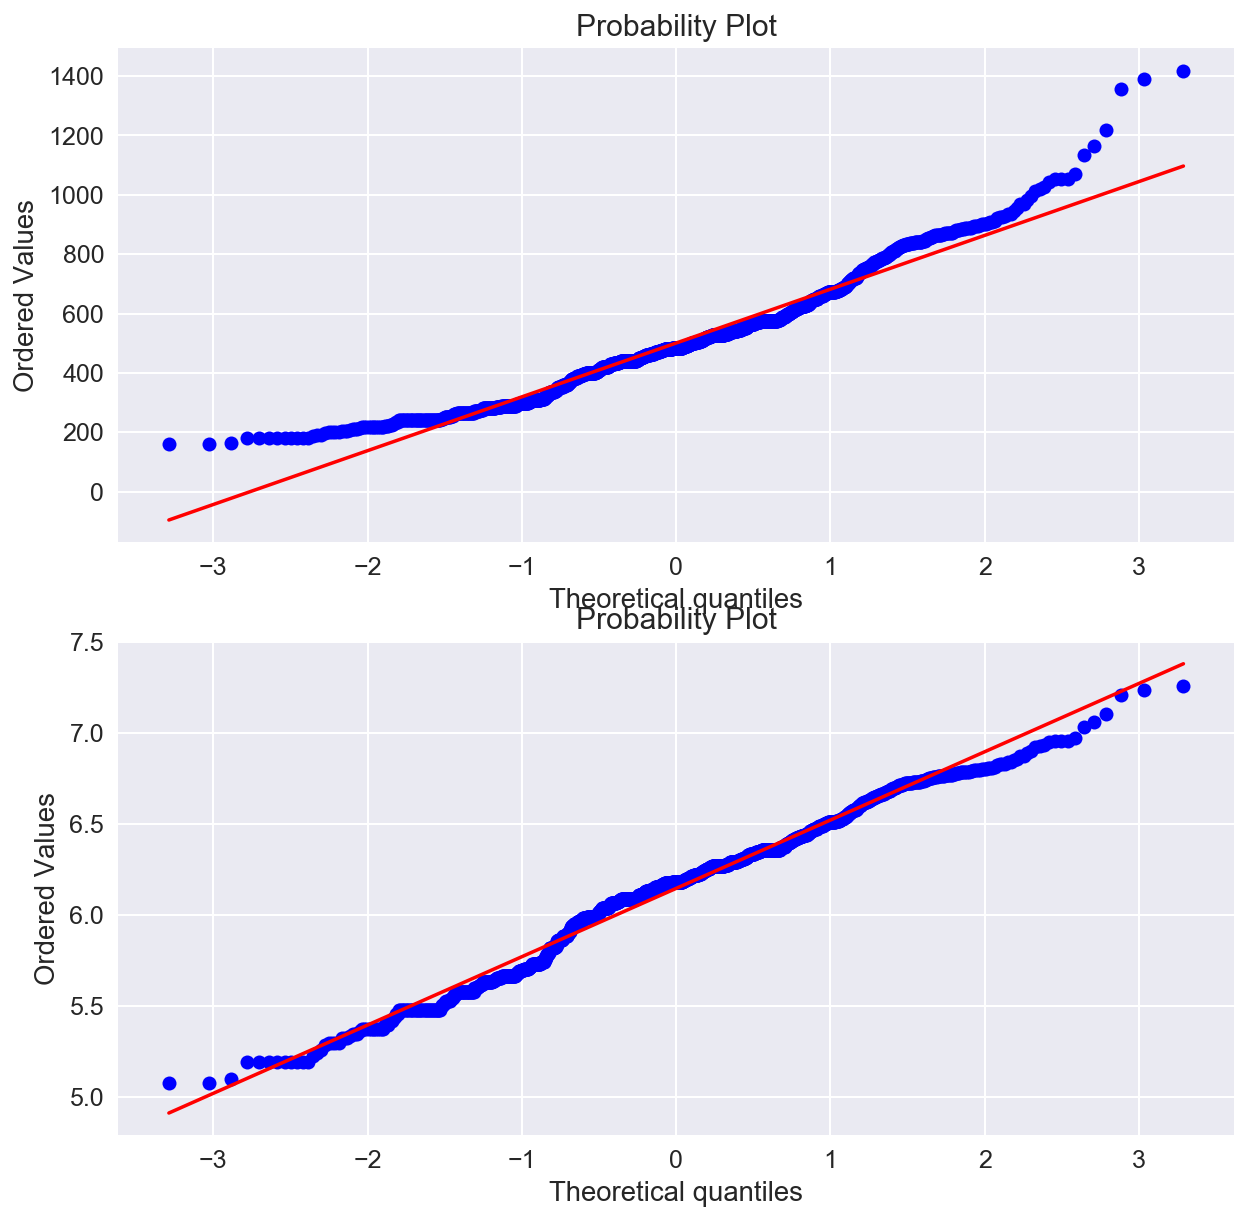

In [42]:
#GarageArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(house[house['GarageArea'] > 0]['GarageArea'], plot=ax1)
house.loc[house['NoGarage'] == 0,'GarageArea'] = np.log(house['GarageArea'])
res = stats.probplot(house[house['GarageArea'] > 0]['GarageArea'], plot=ax2)

In [43]:
#recheck distribution
# f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10,figsize=(7,36))
# sns.distplot(house['SalePrice'], fit=norm, ax=ax1)
# #ax1.set_title('SalePrice')
# sns.distplot(house['OverallQual'], fit=norm, ax=ax2)
# #ax2.set_title('OverallQual')
# sns.distplot(house['FullBath'], fit=norm, ax=ax3)
# sns.distplot(house['GrLivArea'], fit=norm, ax=ax4)
# sns.distplot(house['GarageArea'], fit=norm, ax=ax5)
# sns.distplot(house['GarageCars'], fit=norm, ax=ax6)
# sns.distplot(house['TotalBsmtSF'], fit=norm, ax=ax7)
# sns.distplot(house['1stFlrSF'], fit=norm, ax=ax8)
# sns.distplot(house['TotRmsAbvGrd'], fit=norm, ax=ax9)
# sns.distplot(house['YearBuilt'], fit=norm, ax=ax10)

In [44]:
#making a copy of transformed data without dummies
h_no_dummy = house.copy()

In [45]:
#h = h_no_dummy.copy()

In [46]:
#h = h_no_log.copy()

In [47]:
#adding dummy cols
for col in house.columns:
    if house[col].dtype == 'object':
        dummies = pd.DataFrame()
        dummies = pd.get_dummies(house[col]).rename(columns=lambda x: str(col) + '_' + str(x))
        drop_col = str(col) + '_' + str(house[col].unique()[-1])
        house = pd.concat([house, dummies], axis=1)
        #house = pd.concat([house, pd.get_dummies(house[col])], axis=1)
        del house[col]
        del house[drop_col]

In [48]:
#categorize Mosold and other categorical numerics into dummies too
col = 'MoSold'
dummies = pd.DataFrame()
dummies = pd.get_dummies(house[col]).rename(columns=lambda x: str(col) + '_' + str(x))
drop_col = str(col) + '_' + str(house[col].unique()[-1])
house = pd.concat([house, dummies], axis=1)
del house[col]
del house[drop_col]

In [49]:
#house.columns
#house['MSSubClassCat'].value_counts()[-1]
#house.groupby('MSSubClassCat')['MSSubClassCat'].size().min()
#house['MSSubClassCat'].unique()[-1]
#dummies = pd.get_dummies(house['MSSubClassCat']).rename(columns=lambda x: str('MSSubClassCat') + '_' + str(x))
#dummies = dummies.drop(dummies.columns[0],axis=1)
#len(dummies.columns)

Feature Engineering

In [50]:
#amount of high quality sqft
house['Qualsqft'] = (house.GrLivArea  - house.LowQualFinSF)

#2 storey building, assuming multiple floors is a more desireable house
#house['2story'] = house['2ndFlrSF'] > 0
#house['Y' if house[house['2ndFlrSF'] > 0] else 'N']

#sqft of rooms other than bedrooms, indicative of open concept?
house['oConcept'] = (house['1stFlrSF'] / (house.TotRmsAbvGrd - house.BedroomAbvGr + 1))

#rooms other than bedrooms
house['Rooms'] = (house.TotRmsAbvGrd - house.BedroomAbvGr)

#avg sqft per room
house['SqftPerRoom'] = (house.GrLivArea / house.TotRmsAbvGrd)

#yard size, based on lot size minus all other measured areas we have
house['Yard'] = house.LotArea - house['1stFlrSF'] - house.GarageArea# - house.WoodDeckSF - house.OpenPorchSF - house['3SsnPorch'] - house.ScreenPorch

#bathroom to bed ratio, weighting halfbaths appropriately
house['Bath2Bed'] = ((house.FullBath + (house.HalfBath)*.5) / (house.BedroomAbvGr + 1))

#bathroom to kitchen ratio, weighting halfbaths appropriately
house['Bath2Kitch'] = ((house.FullBath + (house.HalfBath)*.5) / (house.KitchenAbvGr + 1))

#overall quality squared
house['OverallQualSq'] = house['OverallQual'] ** 2

house['QualOnLot'] =  (house['Qualsqft'] ** house['OverallQualSq'])

house['QualOnSqft'] =  (house['GrLivArea'] * house['OverallQualSq'])

house['QualOnRooms'] =  ((house['BedroomAbvGr'] + house['KitchenAbvGr'] + 
                      house['TotRmsAbvGrd'] + house['GarageCars'] + 
                      house['FullBath'] + house['HalfBath'] + 
                      house['BsmtFullBath'] + house['BsmtHalfBath'] + house['Fireplaces']) * house['OverallQualSq'])

house['RoomsOverArea'] = house['TotRmsAbvGrd'] / house['GrLivArea']

#price per bed
#house['PriceRoom'] = house['SalePrice'] / house['TotRmsAbvGrd']# + house['FullBath'] + house['HalfBath']

#price per bed
#house['PriceBed'] = house['SalePrice'] / house['BedroomAbvGr']
#house['SalePrice'] / house['BedroomAbvGr']

#years since renovations
house['YearsBetween'] = house['YearRemodAdd'] - house['YearBuilt']

house['Qualsqft2'] = np.sqrt(house['Qualsqft']) * house['OverallQual'] # * house['sqftperroom']
#house['Qualsqft2'].fillna(0)

house['Qualsqft3'] = np.sqrt(house['Qualsqft']) * house['OverallQualSq'] # * house['sqftperroom']
#house['Qualsqft3'].fillna(0)

house['BKG'] =  (house['Bath2Bed'] * house['Qualsqft'])

#house['PriceOnRooms'] = (house['SalePrice'] / (house['BedroomAbvGr'] + house['KitchenAbvGr'] + house['TotRmsAbvGrd']))

house['BKP'] =  (house['Bath2Kitch'] * house['QualOnRooms'])

/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt


In [51]:
#add features
#(house.groupby('Neighborhood')['SalePrice'].mean() / house.groupby('Neighborhood')['GrLivArea'].mean()).sort_values(ascending=False)

In [52]:
#house['Qualsqft2']
house['Qualsqft2'].fillna(0,inplace=True)
house['Qualsqft3'].fillna(0,inplace=True)
house['QualOnLot'].fillna(0,inplace=True)

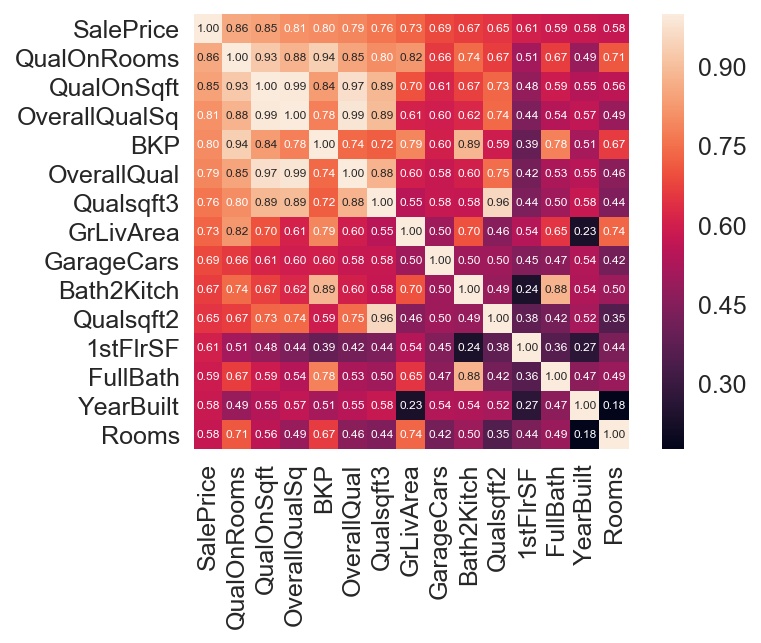

In [53]:
#looking at correlation of new features added

k = 15 #number of variables for heatmap
corr = house.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 6}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [54]:
#added cols to have no Nans
#house.fillna(0,inplace=True)
house.isnull().sum().sort_values(ascending=False).head()

BKP                  0
HouseStyle_1.5Fin    0
Condition2_RRAn      0
Condition2_RRNn      0
BldgType_1Fam        0
dtype: int64

In [57]:
#h = h_dummy.copy()
#fully log transformed and categorical dummies dataset
h_log_dummy = house.copy()

In [58]:
#Create fixed and non-fixed feature dataframes to evaluate separately
h_fixed = h_log_dummy.copy()

In [59]:
h_nonfixed = h_log_dummy.copy()

In [60]:
#fixed features 
fixed_col = []
for col in h_fixed.columns:
    for fix in feature_dict['fixed']:
        if fix in col:
            #del h_fixed[col]
            fixed_col.append(col)
h_fixed = h_fixed[fixed_col]

In [61]:
#non-fixed features 
nonfixed_col = []
for col in h_nonfixed.columns:
    for nonfix in feature_dict['non-fixed']:
        if nonfix in col:
            #del h_fixed[col]
            nonfixed_col.append(col)
h_nonfixed = h_nonfixed[nonfixed_col]

In [62]:
h = h_nonfixed.copy()
#h = h_fixed.copy()

In [63]:
#removing target variable
y = house['SalePrice']
X = house.drop("SalePrice", axis=1)
Xn = house.drop("SalePrice", axis=1)

In [64]:
#X = house
print(X.shape)
print(y.shape)

(1450, 282)
(1450,)


In [65]:
#y

In [66]:
#h = pd.concat([house,y],axis=1)
#h.describe().T.head()

In [67]:
#scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X,columns=Xn.columns)

In [68]:
#creating holdout
from sklearn.model_selection import train_test_split
X_train, X_hold, y_train, y_hold = train_test_split(X,y,test_size=0.2)

In [69]:
#Create new test/train sets from non holdcout copy
X = X_train.copy()
y = y_train.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [70]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8819956881628109

In [71]:
list(zip(X.columns,lr.coef_))[:5]

[('LotArea', 0.018171324996433556),
 ('OverallQual', 0.07036556658803812),
 ('OverallCond', 0.036997831698407466),
 ('YearBuilt', 0.04190907170343614),
 ('YearRemodAdd', 0.033862149571730824)]

In [72]:
np.e**lr.intercept_

167921.39085519614

In [73]:
#r2 doesn't look good, will run through cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=4)
score = cross_val_score(lr,X,y,scoring='neg_mean_squared_error',cv=kfold)
positive_score = -score
np.sqrt(positive_score).mean()

0.15473980329454454

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=4)
score = cross_val_score(lr,X,y,scoring='r2',cv=kfold)
np.mean(score)

0.827905128093135

In [75]:
#regularization needs to be done
from sklearn import linear_model
a = [.0005,.0008,.001,.002,.0025,.003,.0035,.004,.005,.01,.05,.1]
score = []
for i in a:
    reg = linear_model.Lasso(alpha = i)
    reg.fit(X_train,y_train)
    score.append(reg.score(X_test,y_test))
list(zip(a,score))

[(0.0005, 0.8962317213769425),
 (0.0008, 0.8966975914306226),
 (0.001, 0.8964196320812474),
 (0.002, 0.89345869133248),
 (0.0025, 0.8933081767658838),
 (0.003, 0.8943684866417663),
 (0.0035, 0.8948318645378865),
 (0.004, 0.8951768937978949),
 (0.005, 0.8951529147872624),
 (0.01, 0.8821450146858741),
 (0.05, 0.7738287814018814),
 (0.1, 0.6666848805190928)]

Scores look okay I think? Will re-look at the cross-val scores for verifying. Making a function to put a model into the Kfolds and return RMSE.

In [76]:
def cv_rmse(estimator):
    score = cross_val_score(estimator,X,y,scoring='neg_mean_squared_error',cv=kfold)
    positive_score = -score
    return np.sqrt(positive_score) #np.sqrt(positive_score)

In [77]:
cv_rmse(lr).mean()

0.15473980329454454

In [78]:
#going to experiment with lasso
a = [.0005,.0008,.001,.002,.003,.004,.005,.01,.05]
Lasso_rmse = []
Lasso_std = []
for i in a:
    Lasso_rmse.append(cv_rmse(linear_model.Lasso(alpha=i)).mean())
    Lasso_std.append(cv_rmse(linear_model.Lasso(alpha=i)).std())

In [79]:
from pprint import pprint
ls = list(zip(a,Lasso_rmse,Lasso_std))
ls = pd.DataFrame(ls,columns=['Alpha','RMSE','Std'])

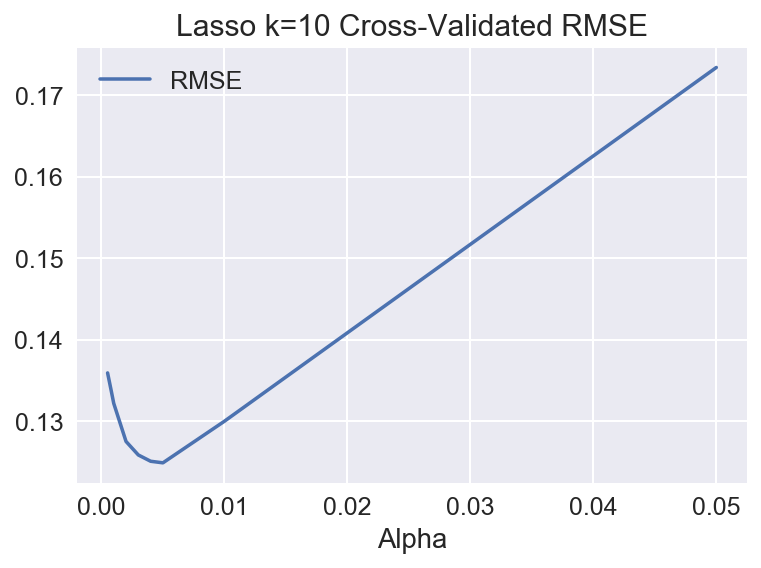

In [80]:
ls.plot('Alpha','RMSE',title='Lasso k=10 Cross-Validated RMSE')

In [81]:
#training lasso on hyperparameter
lasso = linear_model.Lasso(alpha=.004)
lasso.fit(X,y)
Lasso_coef = pd.DataFrame(lasso.coef_,index=Xn.columns)

In [82]:
lasso.score(X_hold,y_hold)

0.9095158502560475

In [83]:
y_pred = lasso.predict(X_hold)

In [84]:
print(X_hold.shape)
print(y_hold.shape)
print(y_pred.shape)

(290, 282)
(290,)
(290,)


In [85]:
#X_hold.reset_index()
lasso_pred = pd.concat([X_hold.reset_index(),y_hold.reset_index(),
                        pd.DataFrame(y_pred,columns=['Pred_SalePrice'])],axis=1)

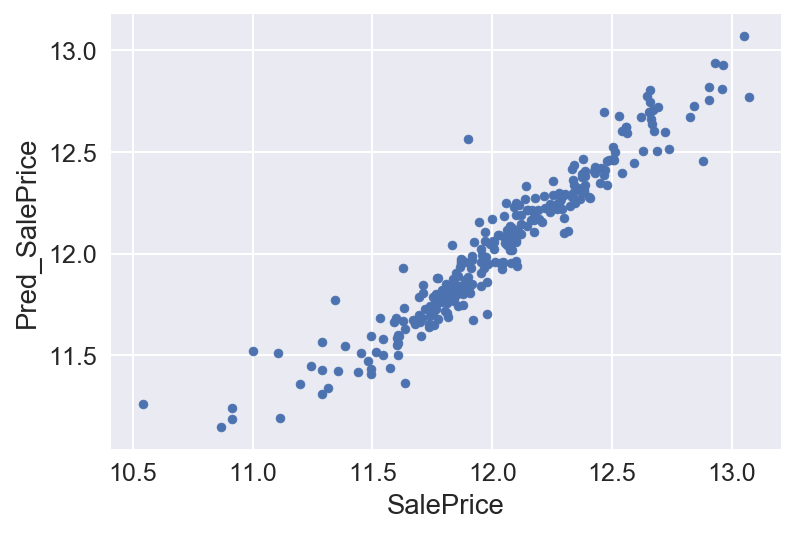

In [86]:
lasso_pred.plot.scatter('SalePrice','Pred_SalePrice')

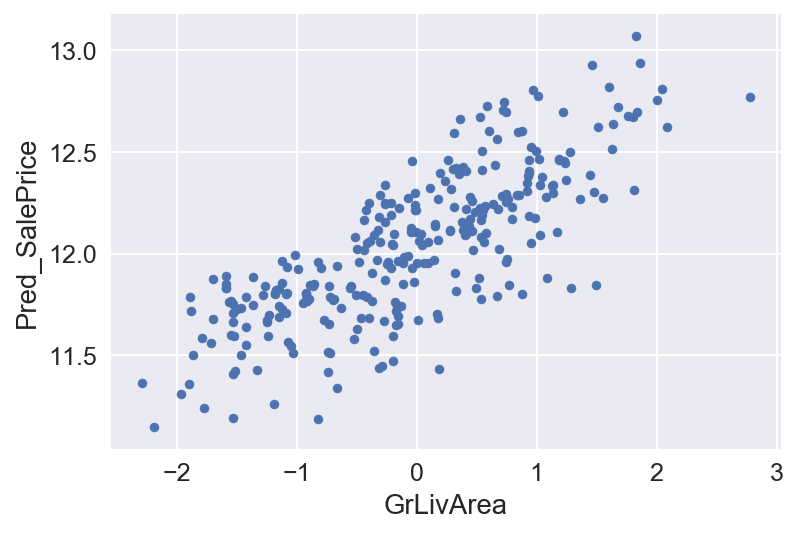

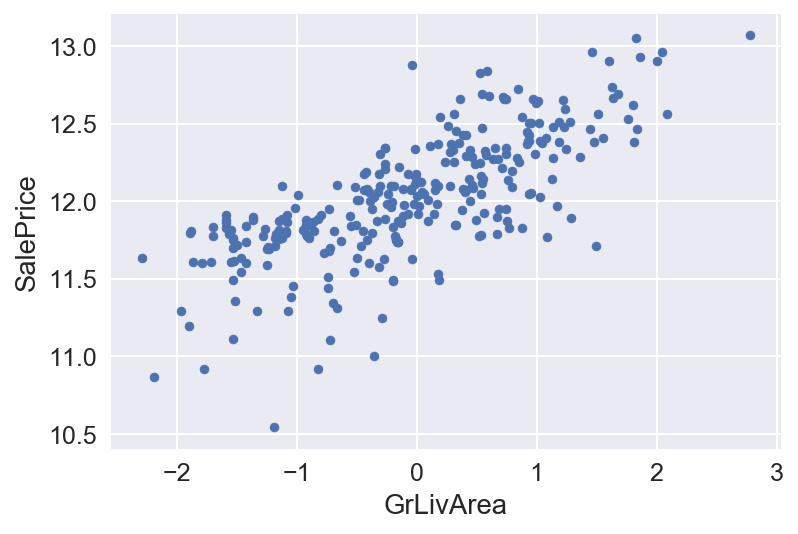

In [87]:
lasso_pred.plot.scatter('GrLivArea','Pred_SalePrice')
lasso_pred.plot.scatter('GrLivArea','SalePrice')

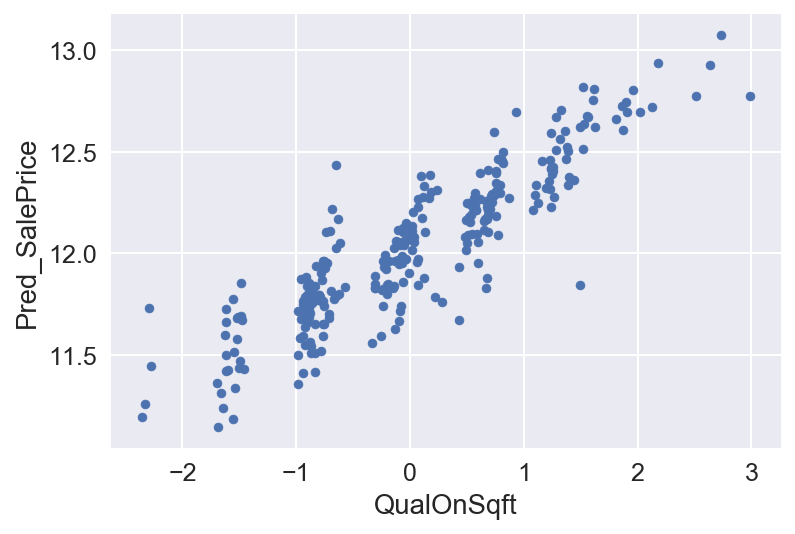

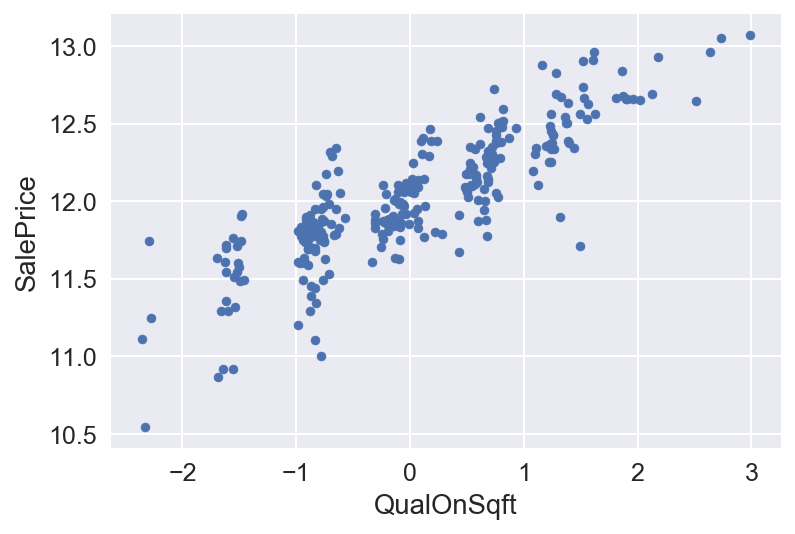

In [88]:
lasso_pred.plot.scatter('QualOnSqft','Pred_SalePrice')
lasso_pred.plot.scatter('QualOnSqft','SalePrice')

In [89]:
#look at lasso strength of top 20 coefficients
#pd.options.display.float_format = '{:,.6f}'.format
#print(Lasso_coef[Lasso_coef[0] > 0].sort_values(by=0,ascending=False).head(20))
print('\nnum of coefs: ' + str(Lasso_coef[Lasso_coef[0] > 0].count()))
print('\n')
print(np.e**lasso.intercept_)


num of coefs: 0    56
dtype: int64


167955.80441793142


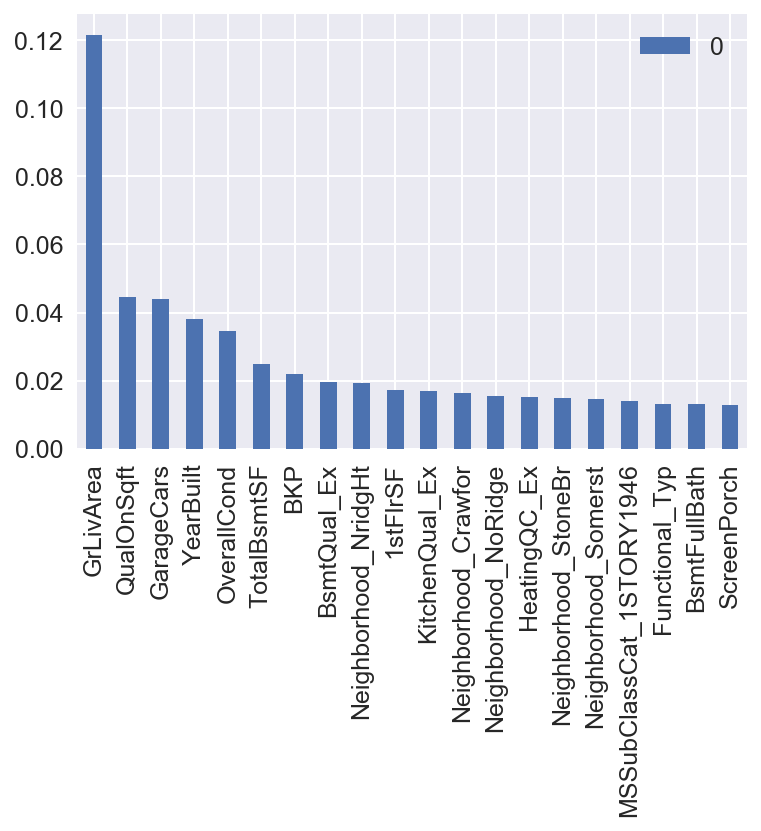

In [90]:
Lasso_coef[Lasso_coef[0] > 0].sort_values(by=0,ascending=False).head(20).plot.bar()

In [91]:
#house[list(Lasso_coef[Lasso_coef[0] > 0].index)].mean()
InvScale = pd.DataFrame()
InvScale['mean'] = house[list(Lasso_coef[Lasso_coef[0] > 0].index)].mean()
InvScale['std'] = house[list(Lasso_coef[Lasso_coef[0] > 0].index)].std()

In [92]:
#InvScale.head()

In [93]:
#InvScale.loc['LotArea','mean']
#Lasso_coef

In [94]:
for feat in list(Lasso_coef[Lasso_coef[0] > 0].index):
    Lasso_coef.loc[feat,1] = Lasso_coef.loc[feat,0] * InvScale.loc[feat,'std'] + InvScale.loc[feat,'mean']
Lasso_coef.columns=['coef','converted']

In [95]:
#Fixed_coef = Lasso_coef.sort_values(by='coef',ascending=False)
h_log_dummy_coef = Lasso_coef.sort_values(by='coef',ascending=False)
#h_dummy_coef = Lasso_coef.sort_values(by='coef',ascending=False)

#Without transforms these are the coeficients
#h_dummy_coef['coef']

#with transforms
a = pd.DataFrame(h_log_dummy_coef['coef'])#.sort_values(by=index)
a = a.reindex_axis(sorted(a.index), axis=0)

#Lasso_coef.sort_values(by='coef',ascending=False)

/Users/shaleniiedevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  # Remove the CWD from sys.path while we load stuff.


In [96]:
#a[a['coef'].abs() > 0]

The intercept is 167,223.

<b>My interpretation of the coeficients:</b><br>
Every unit increase in above ground living area contributes to 12% increase in sale price.<br>
Every unit increase in the combo of GrLivArea * OverallQual^2 contributes to a 6% increase in sale price.<br>
Thought this was a good metric to include because it accounts for both the quality and size.<br>
Every extra car the garage can fit increases sale price by 4.4%.<br>
Every year increase in date built adds 3.8% to sale price.<br>
Every unit increase in overall condition increases sale price 3.9%.

<b>Renovatable features:</b><br>
If one is buying to renovate, the suggestion is to purchase houses with:<br>
Kitchens needing an upgrade (2 point upgrade = 7k increase, though this doesn't make sense?).<br>
Overall condition needing an upgrade.

<b>Summary:</b><br>
I don't feel comfortable with my modeling.I was able to pull more infomation from EDA than from my model.<br>
EDA led me to assume purchasing a single family home in a rising part of town(4-6th top neighbourhoods) would be a good investiment due to price disparity between single family homes in top neighbourhoods and row houses in the others. If I had more time, I would re-evaluate the model output.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [97]:
# A: